## Import Necessary Libraries

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import os
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Load The Dataset
- Early preporcessing has been done such as replace ',' with '.' for numerical data
- Unrelated data has been ignored

In [2]:
data_dir = 'AirQualityUCI/AirQualityUCI.csv'

data_dir_cr = 'AirQualityUCI/AirQualityUCI_cr.csv'

count = 0
f_r = open(data_dir, 'r')
f_w = open(data_dir_cr, 'a')
f_w.truncate(0)
while True:
    line = f_r.readline()
    line = line.replace(',', '.')
    if not line:
        break
    
    f_w.write(line)
        
f_r.close()
f_w.close()
data = pd.read_csv('AirQualityUCI/AirQualityUCI_cr.csv', delimiter=';')
data = data.iloc[:, 2:len(data.columns)-2]
data.dropna(subset = ['CO(GT)'], inplace = True)
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## Plotting histogram for each feature
- Since missing values have been replaced with -200, we have a some distribution where the value < 0.

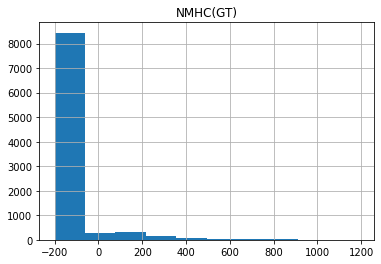

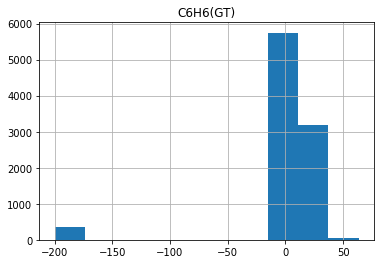

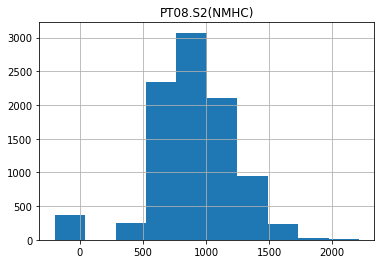

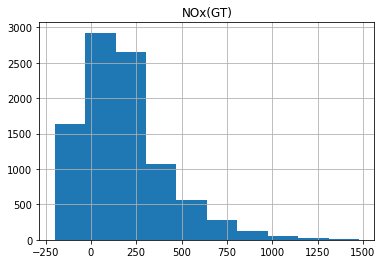

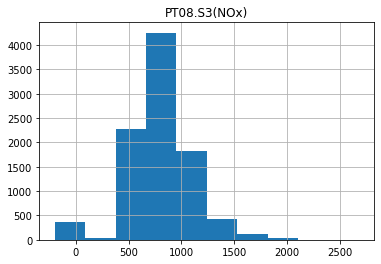

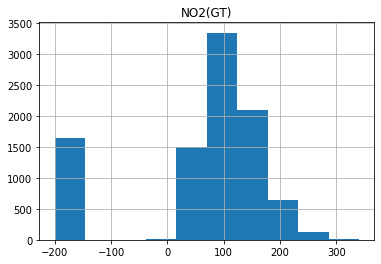

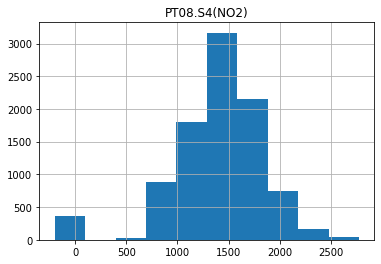

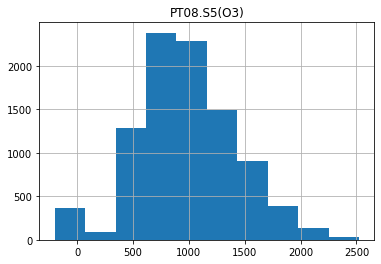

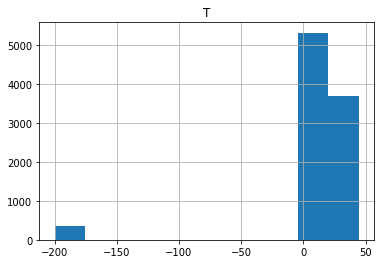

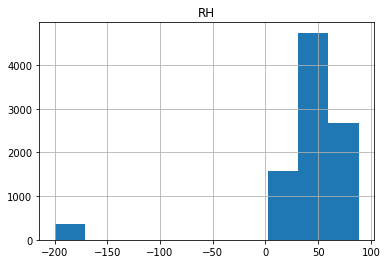

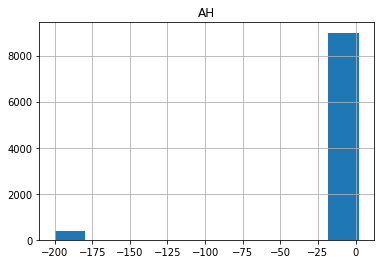

In [3]:
data_hist = data.iloc[:, 2:]
for column in data_hist.columns:
    data.hist(column=column)
    

## Date preprocessing 
- We replace the -200 with nan values for simplicity of pandas functions such as **fillna** and **interpolate**.
- We use interpolate instead of fillna since this is a time series data.

In [4]:
for column in data.columns:
    data[column].replace(-200, np.nan, inplace = True)
    
for column in data.columns:
    #data[column].fillna()
    data[column] = data[column].interpolate()

nans = list(pd.isna(data['NMHC(GT)']))
range_nans = [i for i in range(len(nans)) if nans[i] == True]

data.tail()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,3.1,1314.0,275.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2.4,1163.0,275.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2.4,1142.0,275.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2.1,1003.0,275.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,2.2,1071.0,275.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


## Histogram analysis
- Now we dont have any negative values in the distribution.


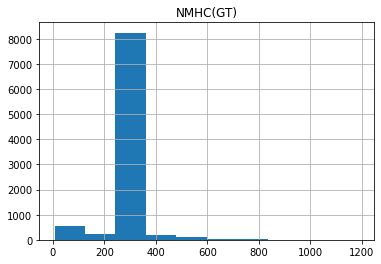

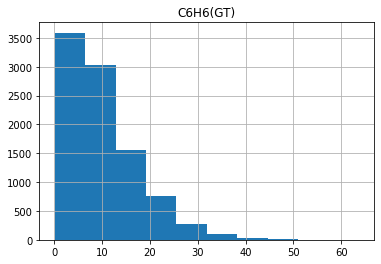

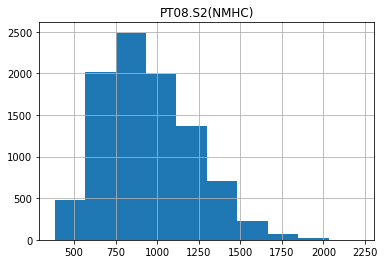

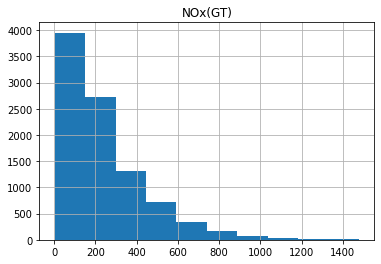

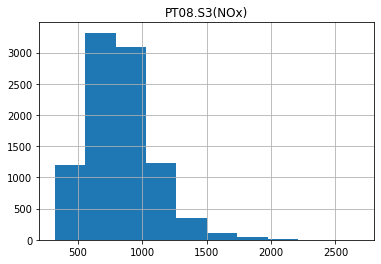

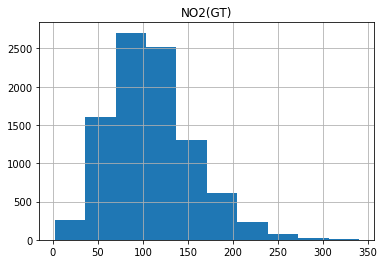

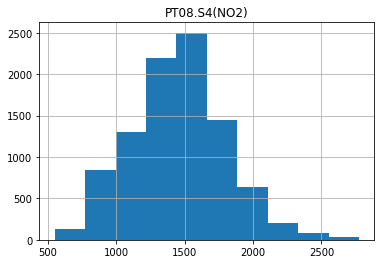

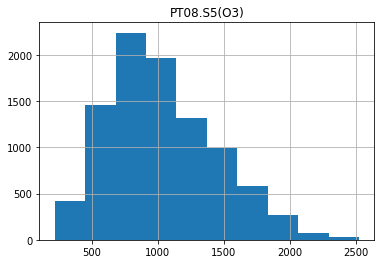

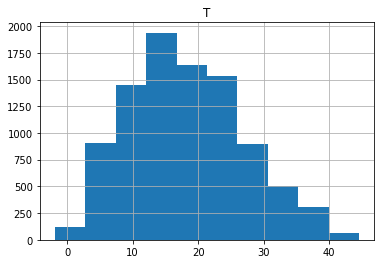

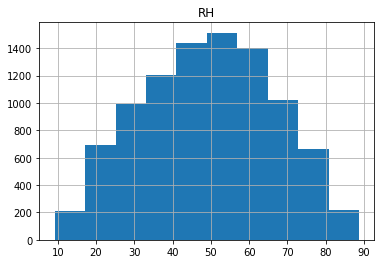

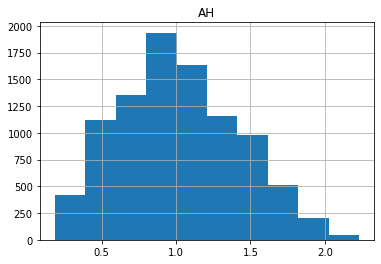

In [5]:
data_hist = data.iloc[:, 2:]
for column in data_hist.columns:
    data.hist(column=column)

## Series to Supervised function is used to generate SLD
- The function takes input as,
    - The time series data
    - required number of inputs (time steps)
    - required number of outputs (no of target samples)
- The function outputs the sequence of t-n to t-1 inputs of time series along with the output which is at time step t.
- For this example input sequence  with 10 timesteps has been chosen.
- We are using LSTM for the forecasting task which can handle relatively higher time steps.

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, column_names = None): 
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (column_names[j], j+1 , i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (column_names[j], j+1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (column_names[j], j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [7]:
values = data.values
columns = data.columns
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
time_steps = 10
outputs = 1
reframed = series_to_supervised(scaled, time_steps, outputs, column_names = columns)
reframed.columns


Index(['CO(GT)1(t-10)', 'PT08.S1(CO)2(t-10)', 'NMHC(GT)3(t-10)',
       'C6H6(GT)4(t-10)', 'PT08.S2(NMHC)5(t-10)', 'NOx(GT)6(t-10)',
       'PT08.S3(NOx)7(t-10)', 'NO2(GT)8(t-10)', 'PT08.S4(NO2)9(t-10)',
       'PT08.S5(O3)10(t-10)',
       ...
       'C6H6(GT)4(t)', 'PT08.S2(NMHC)5(t)', 'NOx(GT)6(t)', 'PT08.S3(NOx)7(t)',
       'NO2(GT)8(t)', 'PT08.S4(NO2)9(t)', 'PT08.S5(O3)10(t)', 'T11(t)',
       'RH12(t)', 'AH13(t)'],
      dtype='object', length=143)

## We convert the given time series data into SLD.
- Perform train and test split
- Standardize the inputs

In [8]:
reframed_vals = reframed.values
split_val = 0.15
slice_index = len(reframed.columns)-len(columns)
train_split_val = int(len(reframed)*(1-split_val))
n_features = len(columns)
train_dataset = reframed_vals[:train_split_val]
train_dataset_df = pd.DataFrame(train_dataset, columns = reframed.columns)
train_x, train_y = train_dataset[:, 0:slice_index], train_dataset[:, slice_index:]
test_x, test_y = reframed_vals[train_split_val:, 0:slice_index], reframed_vals[train_split_val:, slice_index:]


sdt_scaler = StandardScaler()
for i in range(train_x.shape[1]):
    train_x[:, i] = train_x[:, i].astype(np.float32)
    #train_x[:, i] = scaler.fit_transform(train_x[:, i].reshape(-1,1)).reshape(-1)
    train_x[:, i] = sdt_scaler.fit_transform(train_x[:, i].reshape(-1,1)).reshape(-1)
        
for i in range(test_x.shape[1]):
    test_x[:, i] = test_x[:, i].astype(np.float32)
    #test_x[:, i] = scaler.fit_transform(test_x[:, i].reshape(-1,1)).reshape(-1)
    test_x[:, i] = sdt_scaler.fit_transform(test_x[:, i].reshape(-1,1)).reshape(-1)

train_x = train_x.reshape((train_x.shape[0], time_steps, n_features))
test_x = test_x.reshape((test_x.shape[0], time_steps, n_features))

In [9]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(7944, 10, 13) (7944, 13) (1403, 10, 13) (1403, 13)


## Model for Forecasting.
- The build_model function takes as input,
    - no of LSTM units reuired
    - time steps in the input sequence
    - No if features in the sequence
- LSTM with 50 units is used for forecasting.

In [10]:
# design network
def build_model(lstm_units = 50, time_steps = None, outputs = None):
    model = Sequential()
    #model.add(LSTM(lstm_units, input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(LSTM(lstm_units, input_shape=(time_steps, outputs)))
    model.add(Dense(outputs))
    model.compile(loss='mae', optimizer='adam')
    
    return model

## Irregular data set.
- We define the extent of irregularities (in percentage) required in the input in the array, drop_vals.
- For each value in the array drop_vals,
    - We remove the percentage of the samples randomly from training data and store the dataset in a collection.
    

In [11]:
drop_vals = [0, 10, 20, 30] ## In percentages
data_sets = {}
for i in drop_vals:
    remove_n = (int(i) * len(values))//100
    drop_indices = np.random.choice(train_dataset_df.index, remove_n, replace = False)
    data_subset = train_dataset_df.drop(drop_indices)
    data_sets[str(i)] = data_subset

## Training and Evaluation
- We train the model for each level of irregular data (0% - 10% - 20% - 30%)
- We track the training loss and validation loss and store them for further analysis.

In [12]:
histories = {}

for key in data_sets.keys():
    keras.backend.clear_session()
    data_set = data_sets[key].values
    train_x, train_y = data_set[:, 0:slice_index], data_set[:, slice_index:]
    train_x = train_x.reshape((train_x.shape[0], time_steps, n_features))

    lstm_model = build_model(lstm_units = 50, time_steps=time_steps, outputs = n_features)
    history = lstm_model.fit(train_x, train_y, epochs=50, batch_size=72, validation_data=(test_x, test_y), verbose=0, shuffle=False)
    histories[key] = history
    keras.backend.clear_session()
    print(f'{key} done')

0 done
10 done
20 done
30 done


### We can see that the validation loss platues at around 15 epochs for all the participants

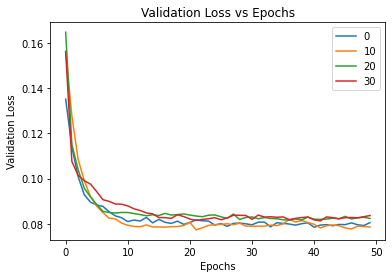

In [13]:
for key in histories.keys():
    pyplot.plot(histories[key].history['val_loss'], label=key)
pyplot.xlabel('Epochs')
pyplot.ylabel('Validation Loss')
pyplot.title('Validation Loss vs Epochs')
pyplot.legend()
pyplot.show()

### We Retrain the models for 15 Epochs

In [14]:
for key in data_sets.keys():
    keras.backend.clear_session()
    data_set = data_sets[key].values
    train_x, train_y = data_set[:, 0:slice_index], data_set[:, slice_index:]
    train_x = train_x.reshape((train_x.shape[0], time_steps, n_features))

    lstm_model = build_model(lstm_units = 50, time_steps=time_steps, outputs = n_features)
    history = lstm_model.fit(train_x, train_y, epochs=15, batch_size=72, validation_data=(test_x, test_y), verbose=0, shuffle=False)
    histories[key] = history
    keras.backend.clear_session()
    print(f'{key} done')

0 done
10 done
20 done
30 done


### The validation loss converges quickly for each of the models, However the the values at which they saturate increases with increase in irregularity

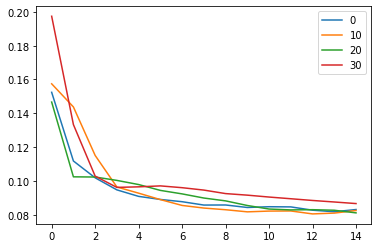

In [15]:
for key in histories.keys():
    pyplot.plot(histories[key].history['val_loss'], label=key)
pyplot.legend()
pyplot.show()

## Mean validation Loss vs Irregularities (in percentage)
- We plot the mean validation loss of each model with respective irregularities in data.
- We find that the mean validation increases with increasing irregularity.

No handles with labels found to put in legend.


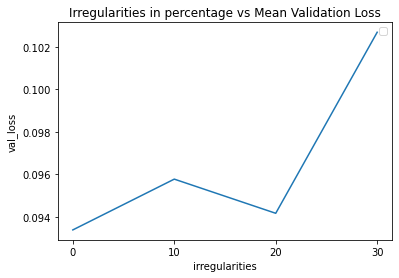

In [16]:
mean_val_loss = [np.mean(histories[i].history['val_loss']) for i in histories]
pyplot.plot([key for key in histories.keys()], mean_val_loss)
pyplot.xlabel('irregularities')
pyplot.ylabel('val_loss')
pyplot.title('Irregularities in percentage vs Mean Validation Loss')
pyplot.legend()
pyplot.show()
